In [1]:
import os 
import cv2 
import numpy as np 
from tqdm import tqdm 

REBUILD_DATA = True

In [2]:
class DogsVsCats():

    #the image size
    IMG_SIZE = 75

    #list the dirs
    CATS = "F:\dog\PetImages\Cat"
    DOGS = "F:\dog\PetImages\Dog"

    #write the labels down
    LABELS = {CATS: 0, DOGS:1}

    #create epmty training data array
    training_data = []
    
    #initialize the counters
    catcount = 0
    dogcount = 0


    #data preprocessing  
    def make_training_data(self):
        #looping over cats and dogs
        for label in self.LABELS:
            print(label)
            #run down the pictures of this folder
            for f in tqdm(os.listdir(label)):
                try:
                    #trying to make the full path to this image
                    path = os.path.join(label, f)
                    #read the image and grayscale it 
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    #resize the pic 
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                    #append the pic and one-hot encoded label (corresponding slice of an identity matrix)
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    #if the label is cats - increase the cat counter
                    if label == self.CATS:
                        self.catcount+=1

                    #is the label is dog - increase the dog counter
                    elif label ==self.DOGS:
                        self.dogcount+=1

                #pass the exceptions
                except Exception as e:
                    print(e)
                    pass

        #shuffle the data
        np.random.shuffle(self.training_data)

        #save the data
        np.save("training_data.npy", self.training_data)
        
        #print the count stats
        print(self.catcount)
        print(self.dogcount)

#run the thing
if REBUILD_DATA :
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

F:\dog\PetImages\Cat


100%|██████████| 12501/12501 [00:18<00:00, 662.89it/s]


F:\dog\PetImages\Dog


100%|██████████| 12501/12501 [00:21<00:00, 587.95it/s]
C:\Users\Eitan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


12476
12470


In [3]:
training = np.load("training_data.npy", allow_pickle=True)

In [4]:
print(len(training))

24946


[1. 0.]


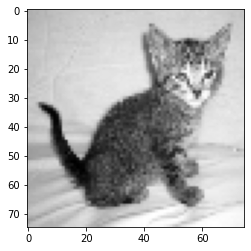

In [5]:
import matplotlib.pyplot as plt

plt.imshow(training[7][0], cmap="gray")
print(training[7][1])

# Now to create the network and train it

In [6]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #convolutional layers
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        self.conv4 = nn.Conv2d(128,256,1)

        #dummy forward pass to find out what the CONV resulting shape is 
        dummy = torch.rand(75,75).view(-1,1,75,75)
        self.to_linear = None
        self.convs(dummy)

        #linear head
        self.fc1 = nn.Linear(self.to_linear, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512,2)


    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))

        print(x[0].shape)
        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x 


    def forward(self, x):

        #convolution 
        x = self.convs(x)
        x = x.view(-1, self.to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim = 1)

    

In [8]:
net = Net()
net.forward

torch.Size([256, 2, 2])


<bound method Net.forward of Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)>

In [9]:
#
import torch.optim as optim 

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

#convert dataset to tensor form 
X = torch.Tensor([i[0] for i in training]).view(-1, 75,75)

X = X/255.0
y = torch.Tensor([i[1]for i in training])


VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [10]:
#train-test split
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [11]:
BATCH_SIZE = 100
EPOCHS = 5

#the training loop
for epoch in (range(EPOCHS)):
    for i in tqdm(range(0,len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,75,75)
        batch_y = train_y[i:i+BATCH_SIZE]

        #clear all the gradients
        net.zero_grad()

        #generate network output
        outputs = net(batch_X)

        #calc the loss
        loss = loss_function(outputs, batch_y)

        #propogate the loss backwards
        loss.backward()
        optimizer.step()

print(loss)



  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 2, 2])


  0%|          | 1/225 [00:01<03:47,  1.02s/it]

torch.Size([256, 2, 2])


  1%|          | 2/225 [00:02<03:42,  1.00it/s]

torch.Size([256, 2, 2])


  1%|▏         | 3/225 [00:03<03:50,  1.04s/it]

torch.Size([256, 2, 2])


  2%|▏         | 4/225 [00:04<04:06,  1.12s/it]

torch.Size([256, 2, 2])


  2%|▏         | 5/225 [00:05<03:54,  1.06s/it]

torch.Size([256, 2, 2])


  3%|▎         | 6/225 [00:06<03:50,  1.05s/it]

torch.Size([256, 2, 2])


  3%|▎         | 7/225 [00:07<03:46,  1.04s/it]

torch.Size([256, 2, 2])


  4%|▎         | 8/225 [00:08<03:35,  1.01it/s]

torch.Size([256, 2, 2])


  4%|▍         | 9/225 [00:09<03:19,  1.08it/s]

torch.Size([256, 2, 2])


  4%|▍         | 10/225 [00:09<03:12,  1.12it/s]

torch.Size([256, 2, 2])


  5%|▍         | 11/225 [00:10<03:23,  1.05it/s]

torch.Size([256, 2, 2])


  5%|▌         | 12/225 [00:12<03:42,  1.04s/it]

torch.Size([256, 2, 2])


  6%|▌         | 13/225 [00:13<03:53,  1.10s/it]

torch.Size([256, 2, 2])


  6%|▌         | 14/225 [00:14<04:06,  1.17s/it]

torch.Size([256, 2, 2])


  7%|▋         | 15/225 [00:15<03:49,  1.09s/it]

torch.Size([256, 2, 2])


  7%|▋         | 16/225 [00:16<03:47,  1.09s/it]

torch.Size([256, 2, 2])


  8%|▊         | 17/225 [00:17<03:42,  1.07s/it]

torch.Size([256, 2, 2])


  8%|▊         | 18/225 [00:18<03:39,  1.06s/it]

torch.Size([256, 2, 2])


  8%|▊         | 19/225 [00:19<03:25,  1.00it/s]

torch.Size([256, 2, 2])


  9%|▉         | 20/225 [00:20<03:09,  1.08it/s]

torch.Size([256, 2, 2])


  9%|▉         | 21/225 [00:21<03:10,  1.07it/s]

torch.Size([256, 2, 2])


 10%|▉         | 22/225 [00:22<03:26,  1.02s/it]

torch.Size([256, 2, 2])


 10%|█         | 23/225 [00:23<03:33,  1.05s/it]

torch.Size([256, 2, 2])


 11%|█         | 24/225 [00:24<03:38,  1.09s/it]

torch.Size([256, 2, 2])


 11%|█         | 25/225 [00:25<03:27,  1.04s/it]

torch.Size([256, 2, 2])


 12%|█▏        | 26/225 [00:26<03:14,  1.02it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 27/225 [00:27<03:05,  1.07it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 28/225 [00:28<03:02,  1.08it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 29/225 [00:29<02:55,  1.12it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 30/225 [00:30<02:50,  1.14it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 31/225 [00:30<02:46,  1.17it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 32/225 [00:31<02:42,  1.18it/s]

torch.Size([256, 2, 2])


 15%|█▍        | 33/225 [00:32<02:42,  1.18it/s]

torch.Size([256, 2, 2])


 15%|█▌        | 34/225 [00:33<02:40,  1.19it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 35/225 [00:34<02:45,  1.15it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 36/225 [00:35<02:56,  1.07it/s]

torch.Size([256, 2, 2])


 16%|█▋        | 37/225 [00:36<02:55,  1.07it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 38/225 [00:37<02:47,  1.12it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 39/225 [00:37<02:40,  1.16it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 40/225 [00:38<02:35,  1.19it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 41/225 [00:39<02:40,  1.15it/s]

torch.Size([256, 2, 2])


 19%|█▊        | 42/225 [00:40<02:46,  1.10it/s]

torch.Size([256, 2, 2])


 19%|█▉        | 43/225 [00:41<02:44,  1.10it/s]

torch.Size([256, 2, 2])


 20%|█▉        | 44/225 [00:42<02:44,  1.10it/s]

torch.Size([256, 2, 2])


 20%|██        | 45/225 [00:43<02:44,  1.10it/s]

torch.Size([256, 2, 2])


 20%|██        | 46/225 [00:44<02:40,  1.12it/s]

torch.Size([256, 2, 2])


 21%|██        | 47/225 [00:45<02:36,  1.14it/s]

torch.Size([256, 2, 2])


 21%|██▏       | 48/225 [00:45<02:36,  1.13it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 49/225 [00:46<02:32,  1.16it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 50/225 [00:47<02:33,  1.14it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 51/225 [00:48<02:29,  1.16it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 52/225 [00:49<02:30,  1.15it/s]

torch.Size([256, 2, 2])


 24%|██▎       | 53/225 [00:50<02:27,  1.17it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 54/225 [00:51<02:24,  1.18it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 55/225 [00:51<02:21,  1.20it/s]

torch.Size([256, 2, 2])


 25%|██▍       | 56/225 [00:52<02:20,  1.20it/s]

torch.Size([256, 2, 2])


 25%|██▌       | 57/225 [00:53<02:19,  1.20it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 58/225 [00:54<02:26,  1.14it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 59/225 [00:55<02:32,  1.09it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 60/225 [00:56<02:34,  1.07it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 61/225 [00:57<02:26,  1.12it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 62/225 [00:58<02:22,  1.14it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 63/225 [00:58<02:19,  1.16it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 64/225 [00:59<02:15,  1.19it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 65/225 [01:00<02:15,  1.18it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 66/225 [01:01<02:13,  1.20it/s]

torch.Size([256, 2, 2])


 30%|██▉       | 67/225 [01:02<02:10,  1.21it/s]

torch.Size([256, 2, 2])


 30%|███       | 68/225 [01:03<02:10,  1.20it/s]

torch.Size([256, 2, 2])


 31%|███       | 69/225 [01:03<02:10,  1.19it/s]

torch.Size([256, 2, 2])


 31%|███       | 70/225 [01:04<02:11,  1.18it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 71/225 [01:05<02:07,  1.21it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 72/225 [01:06<02:06,  1.21it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 73/225 [01:07<02:04,  1.22it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 74/225 [01:07<02:03,  1.22it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 75/225 [01:08<02:02,  1.22it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 76/225 [01:09<02:00,  1.24it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 77/225 [01:10<02:00,  1.23it/s]

torch.Size([256, 2, 2])


 35%|███▍      | 78/225 [01:11<01:59,  1.23it/s]

torch.Size([256, 2, 2])


 35%|███▌      | 79/225 [01:12<01:59,  1.22it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 80/225 [01:12<01:57,  1.23it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 81/225 [01:13<01:56,  1.24it/s]

torch.Size([256, 2, 2])


 36%|███▋      | 82/225 [01:14<01:55,  1.23it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 83/225 [01:15<01:59,  1.19it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 84/225 [01:16<02:03,  1.15it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 85/225 [01:17<01:59,  1.17it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 86/225 [01:18<02:00,  1.15it/s]

torch.Size([256, 2, 2])


 39%|███▊      | 87/225 [01:18<01:58,  1.17it/s]

torch.Size([256, 2, 2])


 39%|███▉      | 88/225 [01:19<01:55,  1.19it/s]

torch.Size([256, 2, 2])


 40%|███▉      | 89/225 [01:20<01:53,  1.20it/s]

torch.Size([256, 2, 2])


 40%|████      | 90/225 [01:21<01:51,  1.21it/s]

torch.Size([256, 2, 2])


 40%|████      | 91/225 [01:22<01:50,  1.22it/s]

torch.Size([256, 2, 2])


 41%|████      | 92/225 [01:22<01:49,  1.22it/s]

torch.Size([256, 2, 2])


 41%|████▏     | 93/225 [01:23<01:48,  1.22it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 94/225 [01:24<01:47,  1.22it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 95/225 [01:25<01:50,  1.18it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 96/225 [01:26<01:48,  1.19it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 97/225 [01:27<01:46,  1.20it/s]

torch.Size([256, 2, 2])


 44%|████▎     | 98/225 [01:27<01:45,  1.20it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 99/225 [01:28<01:44,  1.21it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 100/225 [01:29<01:42,  1.22it/s]

torch.Size([256, 2, 2])


 45%|████▍     | 101/225 [01:30<01:40,  1.23it/s]

torch.Size([256, 2, 2])


 45%|████▌     | 102/225 [01:31<01:39,  1.24it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 103/225 [01:32<01:42,  1.19it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 104/225 [01:32<01:40,  1.21it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 105/225 [01:33<01:38,  1.21it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 106/225 [01:34<01:38,  1.21it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 107/225 [01:35<01:37,  1.22it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 108/225 [01:36<01:35,  1.22it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 109/225 [01:36<01:35,  1.22it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 110/225 [01:37<01:32,  1.24it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 111/225 [01:38<01:32,  1.23it/s]

torch.Size([256, 2, 2])


 50%|████▉     | 112/225 [01:39<01:31,  1.23it/s]

torch.Size([256, 2, 2])


 50%|█████     | 113/225 [01:40<01:30,  1.23it/s]

torch.Size([256, 2, 2])


 51%|█████     | 114/225 [01:41<01:31,  1.22it/s]

torch.Size([256, 2, 2])


 51%|█████     | 115/225 [01:41<01:29,  1.23it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 116/225 [01:42<01:28,  1.23it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 117/225 [01:43<01:28,  1.22it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 118/225 [01:44<01:30,  1.18it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 119/225 [01:45<01:28,  1.20it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 120/225 [01:46<01:26,  1.21it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 121/225 [01:46<01:25,  1.21it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 122/225 [01:47<01:23,  1.23it/s]

torch.Size([256, 2, 2])


 55%|█████▍    | 123/225 [01:48<01:23,  1.22it/s]

torch.Size([256, 2, 2])


 55%|█████▌    | 124/225 [01:49<01:22,  1.23it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 125/225 [01:50<01:21,  1.23it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 126/225 [01:50<01:19,  1.24it/s]

torch.Size([256, 2, 2])


 56%|█████▋    | 127/225 [01:51<01:19,  1.24it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 128/225 [01:52<01:18,  1.23it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 129/225 [01:53<01:17,  1.24it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 130/225 [01:54<01:16,  1.24it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 131/225 [01:54<01:15,  1.24it/s]

torch.Size([256, 2, 2])


 59%|█████▊    | 132/225 [01:55<01:14,  1.24it/s]

torch.Size([256, 2, 2])


 59%|█████▉    | 133/225 [01:56<01:14,  1.23it/s]

torch.Size([256, 2, 2])


 60%|█████▉    | 134/225 [01:57<01:15,  1.20it/s]

torch.Size([256, 2, 2])


 60%|██████    | 135/225 [01:58<01:14,  1.21it/s]

torch.Size([256, 2, 2])


 60%|██████    | 136/225 [01:59<01:13,  1.22it/s]

torch.Size([256, 2, 2])


 61%|██████    | 137/225 [01:59<01:11,  1.22it/s]

torch.Size([256, 2, 2])


 61%|██████▏   | 138/225 [02:00<01:11,  1.22it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 139/225 [02:01<01:10,  1.23it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 140/225 [02:02<01:08,  1.23it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 141/225 [02:03<01:08,  1.23it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 142/225 [02:03<01:08,  1.22it/s]

torch.Size([256, 2, 2])


 64%|██████▎   | 143/225 [02:04<01:07,  1.22it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 144/225 [02:05<01:06,  1.22it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 145/225 [02:06<01:05,  1.21it/s]

torch.Size([256, 2, 2])


 65%|██████▍   | 146/225 [02:07<01:04,  1.22it/s]

torch.Size([256, 2, 2])


 65%|██████▌   | 147/225 [02:08<01:04,  1.22it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 148/225 [02:08<01:02,  1.23it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 149/225 [02:09<01:01,  1.23it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 150/225 [02:10<01:01,  1.23it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 151/225 [02:11<00:59,  1.24it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 152/225 [02:12<00:59,  1.23it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 153/225 [02:12<00:59,  1.20it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 154/225 [02:13<00:57,  1.22it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 155/225 [02:14<00:56,  1.24it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 156/225 [02:15<00:55,  1.24it/s]

torch.Size([256, 2, 2])


 70%|██████▉   | 157/225 [02:16<00:55,  1.23it/s]

torch.Size([256, 2, 2])


 70%|███████   | 158/225 [02:17<00:56,  1.18it/s]

torch.Size([256, 2, 2])


 71%|███████   | 159/225 [02:17<00:54,  1.20it/s]

torch.Size([256, 2, 2])


 71%|███████   | 160/225 [02:18<00:53,  1.21it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 161/225 [02:19<00:53,  1.20it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 162/225 [02:20<00:52,  1.21it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 163/225 [02:21<00:51,  1.21it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 164/225 [02:21<00:49,  1.23it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 165/225 [02:22<00:48,  1.23it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 166/225 [02:23<00:48,  1.23it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 167/225 [02:24<00:47,  1.22it/s]

torch.Size([256, 2, 2])


 75%|███████▍  | 168/225 [02:25<00:46,  1.21it/s]

torch.Size([256, 2, 2])


 75%|███████▌  | 169/225 [02:26<00:45,  1.22it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 170/225 [02:26<00:44,  1.23it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 171/225 [02:27<00:43,  1.23it/s]

torch.Size([256, 2, 2])


 76%|███████▋  | 172/225 [02:28<00:43,  1.22it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 173/225 [02:29<00:43,  1.19it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 174/225 [02:30<00:42,  1.20it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 175/225 [02:31<00:41,  1.20it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 176/225 [02:31<00:40,  1.22it/s]

torch.Size([256, 2, 2])


 79%|███████▊  | 177/225 [02:32<00:39,  1.21it/s]

torch.Size([256, 2, 2])


 79%|███████▉  | 178/225 [02:33<00:38,  1.22it/s]

torch.Size([256, 2, 2])


 80%|███████▉  | 179/225 [02:34<00:37,  1.22it/s]

torch.Size([256, 2, 2])


 80%|████████  | 180/225 [02:35<00:36,  1.22it/s]

torch.Size([256, 2, 2])


 80%|████████  | 181/225 [02:35<00:36,  1.22it/s]

torch.Size([256, 2, 2])


 81%|████████  | 182/225 [02:36<00:35,  1.22it/s]

torch.Size([256, 2, 2])


 81%|████████▏ | 183/225 [02:37<00:34,  1.21it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 184/225 [02:38<00:35,  1.15it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 185/225 [02:39<00:34,  1.14it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 186/225 [02:40<00:35,  1.11it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 187/225 [02:41<00:33,  1.13it/s]

torch.Size([256, 2, 2])


 84%|████████▎ | 188/225 [02:42<00:32,  1.13it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 189/225 [02:43<00:33,  1.09it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 190/225 [02:44<00:35,  1.01s/it]

torch.Size([256, 2, 2])


 85%|████████▍ | 191/225 [02:45<00:35,  1.05s/it]

torch.Size([256, 2, 2])


 85%|████████▌ | 192/225 [02:46<00:35,  1.07s/it]

torch.Size([256, 2, 2])


 86%|████████▌ | 193/225 [02:47<00:32,  1.03s/it]

torch.Size([256, 2, 2])


 86%|████████▌ | 194/225 [02:48<00:30,  1.03it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 195/225 [02:49<00:28,  1.05it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 196/225 [02:50<00:27,  1.06it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 197/225 [02:51<00:25,  1.08it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 198/225 [02:51<00:24,  1.10it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 199/225 [02:52<00:23,  1.11it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 200/225 [02:53<00:22,  1.13it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 201/225 [02:54<00:20,  1.16it/s]

torch.Size([256, 2, 2])


 90%|████████▉ | 202/225 [02:55<00:19,  1.18it/s]

torch.Size([256, 2, 2])


 90%|█████████ | 203/225 [02:56<00:19,  1.14it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 204/225 [02:57<00:18,  1.15it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 205/225 [02:57<00:17,  1.17it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 206/225 [02:58<00:16,  1.18it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 207/225 [02:59<00:15,  1.18it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 208/225 [03:00<00:15,  1.12it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 209/225 [03:01<00:15,  1.05it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 210/225 [03:02<00:15,  1.00s/it]

torch.Size([256, 2, 2])


 94%|█████████▍| 211/225 [03:03<00:13,  1.01it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 212/225 [03:04<00:12,  1.07it/s]

torch.Size([256, 2, 2])


 95%|█████████▍| 213/225 [03:05<00:11,  1.05it/s]

torch.Size([256, 2, 2])


 95%|█████████▌| 214/225 [03:06<00:10,  1.01it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 215/225 [03:07<00:09,  1.02it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 216/225 [03:08<00:08,  1.03it/s]

torch.Size([256, 2, 2])


 96%|█████████▋| 217/225 [03:09<00:07,  1.07it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 218/225 [03:10<00:06,  1.03it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 219/225 [03:11<00:06,  1.02s/it]

torch.Size([256, 2, 2])


 98%|█████████▊| 220/225 [03:12<00:04,  1.04it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 221/225 [03:13<00:03,  1.11it/s]

torch.Size([256, 2, 2])


 99%|█████████▊| 222/225 [03:14<00:02,  1.16it/s]

torch.Size([256, 2, 2])


 99%|█████████▉| 223/225 [03:14<00:01,  1.19it/s]

torch.Size([256, 2, 2])


100%|█████████▉| 224/225 [03:15<00:00,  1.19it/s]

torch.Size([256, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 2, 2])


  0%|          | 1/225 [00:00<02:51,  1.30it/s]

torch.Size([256, 2, 2])


  1%|          | 2/225 [00:01<02:48,  1.32it/s]

torch.Size([256, 2, 2])


  1%|▏         | 3/225 [00:02<02:51,  1.29it/s]

torch.Size([256, 2, 2])


  2%|▏         | 4/225 [00:03<02:47,  1.32it/s]

torch.Size([256, 2, 2])


  2%|▏         | 5/225 [00:03<02:47,  1.32it/s]

torch.Size([256, 2, 2])


  3%|▎         | 6/225 [00:04<02:46,  1.32it/s]

torch.Size([256, 2, 2])


  3%|▎         | 7/225 [00:05<02:47,  1.30it/s]

torch.Size([256, 2, 2])


  4%|▎         | 8/225 [00:06<03:02,  1.19it/s]

torch.Size([256, 2, 2])


  4%|▍         | 9/225 [00:07<03:14,  1.11it/s]

torch.Size([256, 2, 2])


  4%|▍         | 10/225 [00:08<03:36,  1.01s/it]

torch.Size([256, 2, 2])


  5%|▍         | 11/225 [00:09<03:23,  1.05it/s]

torch.Size([256, 2, 2])


  5%|▌         | 12/225 [00:10<03:12,  1.11it/s]

torch.Size([256, 2, 2])


  6%|▌         | 13/225 [00:11<03:28,  1.02it/s]

torch.Size([256, 2, 2])


  6%|▌         | 14/225 [00:12<03:36,  1.02s/it]

torch.Size([256, 2, 2])


  7%|▋         | 15/225 [00:13<03:21,  1.04it/s]

torch.Size([256, 2, 2])


  7%|▋         | 16/225 [00:14<03:15,  1.07it/s]

torch.Size([256, 2, 2])


  8%|▊         | 17/225 [00:15<03:07,  1.11it/s]

torch.Size([256, 2, 2])


  8%|▊         | 18/225 [00:15<02:57,  1.16it/s]

torch.Size([256, 2, 2])


  8%|▊         | 19/225 [00:16<02:54,  1.18it/s]

torch.Size([256, 2, 2])


  9%|▉         | 20/225 [00:17<03:02,  1.12it/s]

torch.Size([256, 2, 2])


  9%|▉         | 21/225 [00:18<02:56,  1.16it/s]

torch.Size([256, 2, 2])


 10%|▉         | 22/225 [00:19<02:47,  1.21it/s]

torch.Size([256, 2, 2])


 10%|█         | 23/225 [00:19<02:38,  1.27it/s]

torch.Size([256, 2, 2])


 11%|█         | 24/225 [00:20<02:33,  1.31it/s]

torch.Size([256, 2, 2])


 11%|█         | 25/225 [00:21<02:29,  1.33it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 26/225 [00:21<02:25,  1.36it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 27/225 [00:22<02:25,  1.36it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 28/225 [00:23<02:22,  1.38it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 29/225 [00:24<02:21,  1.39it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 30/225 [00:24<02:21,  1.38it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 31/225 [00:25<02:19,  1.39it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 32/225 [00:26<02:18,  1.40it/s]

torch.Size([256, 2, 2])


 15%|█▍        | 33/225 [00:27<02:32,  1.26it/s]

torch.Size([256, 2, 2])


 15%|█▌        | 34/225 [00:28<02:35,  1.23it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 35/225 [00:28<02:34,  1.23it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 36/225 [00:29<02:36,  1.21it/s]

torch.Size([256, 2, 2])


 16%|█▋        | 37/225 [00:30<02:28,  1.26it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 38/225 [00:31<02:29,  1.25it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 39/225 [00:31<02:22,  1.30it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 40/225 [00:32<02:18,  1.33it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 41/225 [00:33<02:20,  1.31it/s]

torch.Size([256, 2, 2])


 19%|█▊        | 42/225 [00:34<02:16,  1.34it/s]

torch.Size([256, 2, 2])


 19%|█▉        | 43/225 [00:34<02:12,  1.37it/s]

torch.Size([256, 2, 2])


 20%|█▉        | 44/225 [00:35<02:09,  1.39it/s]

torch.Size([256, 2, 2])


 20%|██        | 45/225 [00:36<02:05,  1.44it/s]

torch.Size([256, 2, 2])


 20%|██        | 46/225 [00:36<02:03,  1.45it/s]

torch.Size([256, 2, 2])


 21%|██        | 47/225 [00:37<02:03,  1.45it/s]

torch.Size([256, 2, 2])


 21%|██▏       | 48/225 [00:38<02:11,  1.34it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 49/225 [00:39<02:07,  1.38it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 50/225 [00:39<02:02,  1.43it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 51/225 [00:40<01:58,  1.46it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 52/225 [00:41<01:57,  1.47it/s]

torch.Size([256, 2, 2])


 24%|██▎       | 53/225 [00:41<01:56,  1.48it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 54/225 [00:42<01:56,  1.47it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 55/225 [00:43<01:56,  1.46it/s]

torch.Size([256, 2, 2])


 25%|██▍       | 56/225 [00:43<01:51,  1.51it/s]

torch.Size([256, 2, 2])


 25%|██▌       | 57/225 [00:44<01:52,  1.50it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 58/225 [00:45<01:50,  1.51it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 59/225 [00:45<01:54,  1.45it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 60/225 [00:46<01:56,  1.42it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 61/225 [00:47<01:53,  1.44it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 62/225 [00:47<01:52,  1.45it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 63/225 [00:48<01:48,  1.49it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 64/225 [00:49<01:49,  1.47it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 65/225 [00:50<01:53,  1.41it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 66/225 [00:50<01:48,  1.47it/s]

torch.Size([256, 2, 2])


 30%|██▉       | 67/225 [00:51<01:51,  1.42it/s]

torch.Size([256, 2, 2])


 30%|███       | 68/225 [00:52<01:51,  1.41it/s]

torch.Size([256, 2, 2])


 31%|███       | 69/225 [00:52<01:48,  1.44it/s]

torch.Size([256, 2, 2])


 31%|███       | 70/225 [00:53<01:48,  1.42it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 71/225 [00:54<01:45,  1.46it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 72/225 [00:54<01:42,  1.50it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 73/225 [00:55<01:44,  1.46it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 74/225 [00:56<01:43,  1.46it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 75/225 [00:56<01:41,  1.47it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 76/225 [00:57<01:39,  1.50it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 77/225 [00:58<01:39,  1.49it/s]

torch.Size([256, 2, 2])


 35%|███▍      | 78/225 [00:58<01:36,  1.53it/s]

torch.Size([256, 2, 2])


 35%|███▌      | 79/225 [00:59<01:36,  1.51it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 80/225 [01:00<01:41,  1.42it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 81/225 [01:00<01:40,  1.44it/s]

torch.Size([256, 2, 2])


 36%|███▋      | 82/225 [01:01<01:36,  1.48it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 83/225 [01:02<01:37,  1.45it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 84/225 [01:03<01:37,  1.44it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 85/225 [01:03<01:34,  1.48it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 86/225 [01:04<01:32,  1.50it/s]

torch.Size([256, 2, 2])


 39%|███▊      | 87/225 [01:05<01:36,  1.43it/s]

torch.Size([256, 2, 2])


 39%|███▉      | 88/225 [01:05<01:35,  1.44it/s]

torch.Size([256, 2, 2])


 40%|███▉      | 89/225 [01:06<01:33,  1.45it/s]

torch.Size([256, 2, 2])


 40%|████      | 90/225 [01:07<01:34,  1.44it/s]

torch.Size([256, 2, 2])


 40%|████      | 91/225 [01:07<01:33,  1.44it/s]

torch.Size([256, 2, 2])


 41%|████      | 92/225 [01:08<01:32,  1.44it/s]

torch.Size([256, 2, 2])


 41%|████▏     | 93/225 [01:09<01:30,  1.45it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 94/225 [01:09<01:26,  1.51it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 95/225 [01:10<01:27,  1.48it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 96/225 [01:11<01:24,  1.52it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 97/225 [01:11<01:25,  1.50it/s]

torch.Size([256, 2, 2])


 44%|████▎     | 98/225 [01:12<01:22,  1.53it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 99/225 [01:13<01:21,  1.54it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 100/225 [01:13<01:24,  1.48it/s]

torch.Size([256, 2, 2])


 45%|████▍     | 101/225 [01:14<01:29,  1.39it/s]

torch.Size([256, 2, 2])


 45%|████▌     | 102/225 [01:15<01:24,  1.45it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 103/225 [01:15<01:23,  1.45it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 104/225 [01:16<01:24,  1.44it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 105/225 [01:17<01:22,  1.46it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 106/225 [01:17<01:19,  1.49it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 107/225 [01:18<01:19,  1.48it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 108/225 [01:19<01:24,  1.38it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 109/225 [01:20<01:21,  1.42it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 110/225 [01:20<01:23,  1.38it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 111/225 [01:21<01:21,  1.39it/s]

torch.Size([256, 2, 2])


 50%|████▉     | 112/225 [01:22<01:20,  1.40it/s]

torch.Size([256, 2, 2])


 50%|█████     | 113/225 [01:22<01:18,  1.43it/s]

torch.Size([256, 2, 2])


 51%|█████     | 114/225 [01:23<01:16,  1.45it/s]

torch.Size([256, 2, 2])


 51%|█████     | 115/225 [01:24<01:16,  1.44it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 116/225 [01:25<01:16,  1.42it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 117/225 [01:25<01:18,  1.38it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 118/225 [01:26<01:16,  1.39it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 119/225 [01:27<01:14,  1.43it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 120/225 [01:27<01:11,  1.47it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 121/225 [01:28<01:11,  1.46it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 122/225 [01:29<01:16,  1.35it/s]

torch.Size([256, 2, 2])


 55%|█████▍    | 123/225 [01:30<01:14,  1.38it/s]

torch.Size([256, 2, 2])


 55%|█████▌    | 124/225 [01:30<01:09,  1.45it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 125/225 [01:31<01:07,  1.48it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 126/225 [01:32<01:10,  1.41it/s]

torch.Size([256, 2, 2])


 56%|█████▋    | 127/225 [01:32<01:08,  1.43it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 128/225 [01:33<01:06,  1.45it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 129/225 [01:34<01:06,  1.44it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 130/225 [01:34<01:07,  1.41it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 131/225 [01:35<01:06,  1.41it/s]

torch.Size([256, 2, 2])


 59%|█████▊    | 132/225 [01:36<01:06,  1.41it/s]

torch.Size([256, 2, 2])


 59%|█████▉    | 133/225 [01:37<01:06,  1.38it/s]

torch.Size([256, 2, 2])


 60%|█████▉    | 134/225 [01:37<01:04,  1.41it/s]

torch.Size([256, 2, 2])


 60%|██████    | 135/225 [01:38<01:03,  1.42it/s]

torch.Size([256, 2, 2])


 60%|██████    | 136/225 [01:39<01:02,  1.43it/s]

torch.Size([256, 2, 2])


 61%|██████    | 137/225 [01:39<00:59,  1.48it/s]

torch.Size([256, 2, 2])


 61%|██████▏   | 138/225 [01:40<00:59,  1.47it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 139/225 [01:41<00:58,  1.48it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 140/225 [01:41<00:57,  1.48it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 141/225 [01:42<01:03,  1.33it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 142/225 [01:43<01:00,  1.37it/s]

torch.Size([256, 2, 2])


 64%|██████▎   | 143/225 [01:44<00:58,  1.41it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 144/225 [01:44<00:56,  1.43it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 145/225 [01:45<00:54,  1.46it/s]

torch.Size([256, 2, 2])


 65%|██████▍   | 146/225 [01:46<00:55,  1.43it/s]

torch.Size([256, 2, 2])


 65%|██████▌   | 147/225 [01:46<00:54,  1.43it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 148/225 [01:47<00:53,  1.44it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 149/225 [01:48<00:52,  1.45it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 150/225 [01:49<00:55,  1.34it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 151/225 [01:49<00:53,  1.37it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 152/225 [01:50<00:52,  1.39it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 153/225 [01:51<00:54,  1.32it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 154/225 [01:52<00:56,  1.25it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 155/225 [01:52<00:53,  1.31it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 156/225 [01:53<00:52,  1.32it/s]

torch.Size([256, 2, 2])


 70%|██████▉   | 157/225 [01:54<00:51,  1.33it/s]

torch.Size([256, 2, 2])


 70%|███████   | 158/225 [01:55<00:49,  1.35it/s]

torch.Size([256, 2, 2])


 71%|███████   | 159/225 [01:55<00:46,  1.41it/s]

torch.Size([256, 2, 2])


 71%|███████   | 160/225 [01:56<00:47,  1.38it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 161/225 [01:57<00:46,  1.38it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 162/225 [01:57<00:45,  1.39it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 163/225 [01:58<00:43,  1.41it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 164/225 [01:59<00:43,  1.41it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 165/225 [01:59<00:42,  1.42it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 166/225 [02:00<00:42,  1.39it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 167/225 [02:01<00:41,  1.40it/s]

torch.Size([256, 2, 2])


 75%|███████▍  | 168/225 [02:02<00:40,  1.39it/s]

torch.Size([256, 2, 2])


 75%|███████▌  | 169/225 [02:03<00:44,  1.26it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 170/225 [02:03<00:43,  1.28it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 171/225 [02:04<00:43,  1.24it/s]

torch.Size([256, 2, 2])


 76%|███████▋  | 172/225 [02:05<00:45,  1.17it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 173/225 [02:06<00:45,  1.14it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 174/225 [02:07<00:47,  1.07it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 175/225 [02:08<00:47,  1.06it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 176/225 [02:09<00:46,  1.06it/s]

torch.Size([256, 2, 2])


 79%|███████▊  | 177/225 [02:10<00:46,  1.03it/s]

torch.Size([256, 2, 2])


 79%|███████▉  | 178/225 [02:11<00:43,  1.09it/s]

torch.Size([256, 2, 2])


 80%|███████▉  | 179/225 [02:12<00:43,  1.06it/s]

torch.Size([256, 2, 2])


 80%|████████  | 180/225 [02:13<00:40,  1.11it/s]

torch.Size([256, 2, 2])


 80%|████████  | 181/225 [02:14<00:38,  1.15it/s]

torch.Size([256, 2, 2])


 81%|████████  | 182/225 [02:14<00:36,  1.16it/s]

torch.Size([256, 2, 2])


 81%|████████▏ | 183/225 [02:15<00:35,  1.17it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 184/225 [02:16<00:38,  1.06it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 185/225 [02:18<00:40,  1.02s/it]

torch.Size([256, 2, 2])


 83%|████████▎ | 186/225 [02:19<00:39,  1.01s/it]

torch.Size([256, 2, 2])


 83%|████████▎ | 187/225 [02:20<00:38,  1.01s/it]

torch.Size([256, 2, 2])


 84%|████████▎ | 188/225 [02:21<00:37,  1.01s/it]

torch.Size([256, 2, 2])


 84%|████████▍ | 189/225 [02:21<00:35,  1.03it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 190/225 [02:22<00:31,  1.12it/s]

torch.Size([256, 2, 2])


 85%|████████▍ | 191/225 [02:23<00:28,  1.19it/s]

torch.Size([256, 2, 2])


 85%|████████▌ | 192/225 [02:24<00:26,  1.24it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 193/225 [02:24<00:25,  1.25it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 194/225 [02:25<00:24,  1.29it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 195/225 [02:26<00:22,  1.31it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 196/225 [02:27<00:22,  1.29it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 197/225 [02:28<00:23,  1.20it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 198/225 [02:28<00:22,  1.20it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 199/225 [02:29<00:20,  1.26it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 200/225 [02:30<00:21,  1.19it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 201/225 [02:31<00:23,  1.03it/s]

torch.Size([256, 2, 2])


 90%|████████▉ | 202/225 [02:32<00:22,  1.03it/s]

torch.Size([256, 2, 2])


 90%|█████████ | 203/225 [02:33<00:21,  1.02it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 204/225 [02:34<00:19,  1.08it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 205/225 [02:35<00:17,  1.16it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 206/225 [02:36<00:15,  1.23it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 207/225 [02:36<00:13,  1.29it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 208/225 [02:37<00:13,  1.29it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 209/225 [02:38<00:12,  1.33it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 210/225 [02:38<00:11,  1.36it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 211/225 [02:39<00:10,  1.37it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 212/225 [02:40<00:09,  1.39it/s]

torch.Size([256, 2, 2])


 95%|█████████▍| 213/225 [02:41<00:08,  1.40it/s]

torch.Size([256, 2, 2])


 95%|█████████▌| 214/225 [02:41<00:07,  1.41it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 215/225 [02:42<00:07,  1.42it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 216/225 [02:43<00:06,  1.42it/s]

torch.Size([256, 2, 2])


 96%|█████████▋| 217/225 [02:43<00:05,  1.44it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 218/225 [02:44<00:04,  1.42it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 219/225 [02:45<00:04,  1.44it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 220/225 [02:45<00:03,  1.44it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 221/225 [02:46<00:02,  1.45it/s]

torch.Size([256, 2, 2])


 99%|█████████▊| 222/225 [02:47<00:02,  1.43it/s]

torch.Size([256, 2, 2])


 99%|█████████▉| 223/225 [02:48<00:01,  1.39it/s]

torch.Size([256, 2, 2])


100%|█████████▉| 224/225 [02:48<00:00,  1.41it/s]

torch.Size([256, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 2, 2])


  0%|          | 1/225 [00:00<02:35,  1.44it/s]

torch.Size([256, 2, 2])


  1%|          | 2/225 [00:01<02:34,  1.45it/s]

torch.Size([256, 2, 2])


  1%|▏         | 3/225 [00:02<02:32,  1.45it/s]

torch.Size([256, 2, 2])


  2%|▏         | 4/225 [00:02<02:32,  1.45it/s]

torch.Size([256, 2, 2])


  2%|▏         | 5/225 [00:03<02:32,  1.44it/s]

torch.Size([256, 2, 2])


  3%|▎         | 6/225 [00:04<02:31,  1.45it/s]

torch.Size([256, 2, 2])


  3%|▎         | 7/225 [00:04<02:32,  1.43it/s]

torch.Size([256, 2, 2])


  4%|▎         | 8/225 [00:05<02:30,  1.45it/s]

torch.Size([256, 2, 2])


  4%|▍         | 9/225 [00:06<02:29,  1.45it/s]

torch.Size([256, 2, 2])


  4%|▍         | 10/225 [00:06<02:29,  1.43it/s]

torch.Size([256, 2, 2])


  5%|▍         | 11/225 [00:07<02:27,  1.45it/s]

torch.Size([256, 2, 2])


  5%|▌         | 12/225 [00:08<02:34,  1.38it/s]

torch.Size([256, 2, 2])


  6%|▌         | 13/225 [00:09<02:32,  1.39it/s]

torch.Size([256, 2, 2])


  6%|▌         | 14/225 [00:09<02:30,  1.41it/s]

torch.Size([256, 2, 2])


  7%|▋         | 15/225 [00:10<02:28,  1.41it/s]

torch.Size([256, 2, 2])


  7%|▋         | 16/225 [00:11<02:33,  1.36it/s]

torch.Size([256, 2, 2])


  8%|▊         | 17/225 [00:12<02:32,  1.36it/s]

torch.Size([256, 2, 2])


  8%|▊         | 18/225 [00:12<02:30,  1.37it/s]

torch.Size([256, 2, 2])


  8%|▊         | 19/225 [00:13<02:31,  1.36it/s]

torch.Size([256, 2, 2])


  9%|▉         | 20/225 [00:14<02:28,  1.38it/s]

torch.Size([256, 2, 2])


  9%|▉         | 21/225 [00:14<02:26,  1.39it/s]

torch.Size([256, 2, 2])


 10%|▉         | 22/225 [00:15<02:23,  1.42it/s]

torch.Size([256, 2, 2])


 10%|█         | 23/225 [00:16<02:21,  1.42it/s]

torch.Size([256, 2, 2])


 11%|█         | 24/225 [00:17<02:21,  1.42it/s]

torch.Size([256, 2, 2])


 11%|█         | 25/225 [00:17<02:21,  1.41it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 26/225 [00:18<02:23,  1.38it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 27/225 [00:19<02:21,  1.40it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 28/225 [00:19<02:18,  1.42it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 29/225 [00:20<02:18,  1.41it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 30/225 [00:21<02:18,  1.41it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 31/225 [00:21<02:15,  1.43it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 32/225 [00:22<02:13,  1.44it/s]

torch.Size([256, 2, 2])


 15%|█▍        | 33/225 [00:23<02:13,  1.44it/s]

torch.Size([256, 2, 2])


 15%|█▌        | 34/225 [00:24<02:13,  1.43it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 35/225 [00:24<02:13,  1.42it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 36/225 [00:25<02:11,  1.44it/s]

torch.Size([256, 2, 2])


 16%|█▋        | 37/225 [00:26<02:11,  1.43it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 38/225 [00:26<02:13,  1.40it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 39/225 [00:27<02:13,  1.40it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 40/225 [00:28<02:10,  1.42it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 41/225 [00:28<02:09,  1.42it/s]

torch.Size([256, 2, 2])


 19%|█▊        | 42/225 [00:29<02:08,  1.43it/s]

torch.Size([256, 2, 2])


 19%|█▉        | 43/225 [00:30<02:07,  1.43it/s]

torch.Size([256, 2, 2])


 20%|█▉        | 44/225 [00:31<02:06,  1.43it/s]

torch.Size([256, 2, 2])


 20%|██        | 45/225 [00:31<02:05,  1.44it/s]

torch.Size([256, 2, 2])


 20%|██        | 46/225 [00:32<02:04,  1.44it/s]

torch.Size([256, 2, 2])


 21%|██        | 47/225 [00:33<02:03,  1.44it/s]

torch.Size([256, 2, 2])


 21%|██▏       | 48/225 [00:33<02:02,  1.44it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 49/225 [00:34<02:02,  1.43it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 50/225 [00:35<02:01,  1.44it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 51/225 [00:35<02:01,  1.43it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 52/225 [00:36<01:59,  1.44it/s]

torch.Size([256, 2, 2])


 24%|██▎       | 53/225 [00:37<01:59,  1.44it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 54/225 [00:38<02:04,  1.37it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 55/225 [00:38<02:02,  1.38it/s]

torch.Size([256, 2, 2])


 25%|██▍       | 56/225 [00:39<02:03,  1.37it/s]

torch.Size([256, 2, 2])


 25%|██▌       | 57/225 [00:40<02:06,  1.32it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 58/225 [00:41<02:08,  1.30it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 59/225 [00:41<02:02,  1.35it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 60/225 [00:42<01:59,  1.38it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 61/225 [00:43<01:57,  1.40it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 62/225 [00:43<01:56,  1.40it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 63/225 [00:44<01:55,  1.40it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 64/225 [00:45<01:54,  1.41it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 65/225 [00:46<01:52,  1.42it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 66/225 [00:46<01:50,  1.43it/s]

torch.Size([256, 2, 2])


 30%|██▉       | 67/225 [00:47<01:49,  1.44it/s]

torch.Size([256, 2, 2])


 30%|███       | 68/225 [00:48<01:56,  1.35it/s]

torch.Size([256, 2, 2])


 31%|███       | 69/225 [00:49<01:59,  1.30it/s]

torch.Size([256, 2, 2])


 31%|███       | 70/225 [00:49<01:56,  1.33it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 71/225 [00:50<01:52,  1.37it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 72/225 [00:51<01:50,  1.39it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 73/225 [00:51<01:48,  1.40it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 74/225 [00:52<01:47,  1.40it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 75/225 [00:53<01:47,  1.39it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 76/225 [00:54<01:48,  1.38it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 77/225 [00:54<01:46,  1.39it/s]

torch.Size([256, 2, 2])


 35%|███▍      | 78/225 [00:55<01:45,  1.39it/s]

torch.Size([256, 2, 2])


 35%|███▌      | 79/225 [00:56<01:44,  1.39it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 80/225 [00:57<01:47,  1.35it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 81/225 [00:57<01:43,  1.39it/s]

torch.Size([256, 2, 2])


 36%|███▋      | 82/225 [00:58<01:41,  1.41it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 83/225 [00:59<01:41,  1.40it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 84/225 [00:59<01:43,  1.36it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 85/225 [01:00<01:40,  1.39it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 86/225 [01:01<01:41,  1.37it/s]

torch.Size([256, 2, 2])


 39%|███▊      | 87/225 [01:02<01:45,  1.31it/s]

torch.Size([256, 2, 2])


 39%|███▉      | 88/225 [01:02<01:45,  1.30it/s]

torch.Size([256, 2, 2])


 40%|███▉      | 89/225 [01:04<02:05,  1.08it/s]

torch.Size([256, 2, 2])


 40%|████      | 90/225 [01:05<02:07,  1.06it/s]

torch.Size([256, 2, 2])


 40%|████      | 91/225 [01:05<01:57,  1.14it/s]

torch.Size([256, 2, 2])


 41%|████      | 92/225 [01:06<01:50,  1.21it/s]

torch.Size([256, 2, 2])


 41%|████▏     | 93/225 [01:07<01:44,  1.26it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 94/225 [01:08<01:42,  1.28it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 95/225 [01:08<01:42,  1.26it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 96/225 [01:09<01:39,  1.29it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 97/225 [01:10<01:45,  1.22it/s]

torch.Size([256, 2, 2])


 44%|████▎     | 98/225 [01:11<01:47,  1.19it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 99/225 [01:12<01:45,  1.20it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 100/225 [01:13<01:40,  1.25it/s]

torch.Size([256, 2, 2])


 45%|████▍     | 101/225 [01:14<01:46,  1.16it/s]

torch.Size([256, 2, 2])


 45%|████▌     | 102/225 [01:15<01:48,  1.13it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 103/225 [01:15<01:42,  1.19it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 104/225 [01:16<01:39,  1.22it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 105/225 [01:17<01:42,  1.17it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 106/225 [01:18<01:45,  1.12it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 107/225 [01:19<01:42,  1.16it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 108/225 [01:19<01:35,  1.22it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 109/225 [01:20<01:33,  1.24it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 110/225 [01:21<01:31,  1.26it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 111/225 [01:22<01:31,  1.25it/s]

torch.Size([256, 2, 2])


 50%|████▉     | 112/225 [01:23<01:28,  1.28it/s]

torch.Size([256, 2, 2])


 50%|█████     | 113/225 [01:23<01:25,  1.31it/s]

torch.Size([256, 2, 2])


 51%|█████     | 114/225 [01:24<01:22,  1.34it/s]

torch.Size([256, 2, 2])


 51%|█████     | 115/225 [01:25<01:21,  1.34it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 116/225 [01:25<01:22,  1.32it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 117/225 [01:26<01:19,  1.36it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 118/225 [01:27<01:17,  1.39it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 119/225 [01:28<01:15,  1.41it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 120/225 [01:28<01:14,  1.41it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 121/225 [01:29<01:16,  1.36it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 122/225 [01:30<01:13,  1.39it/s]

torch.Size([256, 2, 2])


 55%|█████▍    | 123/225 [01:30<01:13,  1.39it/s]

torch.Size([256, 2, 2])


 55%|█████▌    | 124/225 [01:31<01:12,  1.40it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 125/225 [01:32<01:10,  1.41it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 126/225 [01:33<01:10,  1.41it/s]

torch.Size([256, 2, 2])


 56%|█████▋    | 127/225 [01:33<01:09,  1.42it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 128/225 [01:34<01:07,  1.44it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 129/225 [01:35<01:07,  1.43it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 130/225 [01:35<01:06,  1.43it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 131/225 [01:36<01:04,  1.45it/s]

torch.Size([256, 2, 2])


 59%|█████▊    | 132/225 [01:37<01:03,  1.47it/s]

torch.Size([256, 2, 2])


 59%|█████▉    | 133/225 [01:37<01:04,  1.43it/s]

torch.Size([256, 2, 2])


 60%|█████▉    | 134/225 [01:38<01:03,  1.44it/s]

torch.Size([256, 2, 2])


 60%|██████    | 135/225 [01:39<01:02,  1.45it/s]

torch.Size([256, 2, 2])


 60%|██████    | 136/225 [01:39<01:02,  1.44it/s]

torch.Size([256, 2, 2])


 61%|██████    | 137/225 [01:40<01:00,  1.45it/s]

torch.Size([256, 2, 2])


 61%|██████▏   | 138/225 [01:41<01:00,  1.45it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 139/225 [01:42<00:58,  1.47it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 140/225 [01:42<00:57,  1.47it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 141/225 [01:43<00:56,  1.48it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 142/225 [01:44<00:57,  1.44it/s]

torch.Size([256, 2, 2])


 64%|██████▎   | 143/225 [01:44<00:56,  1.45it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 144/225 [01:45<00:55,  1.45it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 145/225 [01:46<00:55,  1.45it/s]

torch.Size([256, 2, 2])


 65%|██████▍   | 146/225 [01:46<00:54,  1.45it/s]

torch.Size([256, 2, 2])


 65%|██████▌   | 147/225 [01:47<00:53,  1.46it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 148/225 [01:48<00:53,  1.45it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 149/225 [01:48<00:53,  1.42it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 150/225 [01:49<00:52,  1.42it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 151/225 [01:50<00:52,  1.41it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 152/225 [01:51<00:51,  1.41it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 153/225 [01:51<00:50,  1.44it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 154/225 [01:52<00:48,  1.46it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 155/225 [01:53<00:47,  1.47it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 156/225 [01:53<00:47,  1.46it/s]

torch.Size([256, 2, 2])


 70%|██████▉   | 157/225 [01:54<00:48,  1.42it/s]

torch.Size([256, 2, 2])


 70%|███████   | 158/225 [01:55<00:47,  1.40it/s]

torch.Size([256, 2, 2])


 71%|███████   | 159/225 [01:55<00:46,  1.42it/s]

torch.Size([256, 2, 2])


 71%|███████   | 160/225 [01:56<00:47,  1.38it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 161/225 [01:57<00:45,  1.42it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 162/225 [01:58<00:44,  1.43it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 163/225 [01:58<00:42,  1.47it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 164/225 [01:59<00:41,  1.47it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 165/225 [02:00<00:40,  1.46it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 166/225 [02:00<00:40,  1.45it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 167/225 [02:01<00:39,  1.47it/s]

torch.Size([256, 2, 2])


 75%|███████▍  | 168/225 [02:02<00:39,  1.46it/s]

torch.Size([256, 2, 2])


 75%|███████▌  | 169/225 [02:02<00:38,  1.47it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 170/225 [02:03<00:37,  1.45it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 171/225 [02:04<00:37,  1.43it/s]

torch.Size([256, 2, 2])


 76%|███████▋  | 172/225 [02:04<00:36,  1.45it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 173/225 [02:05<00:36,  1.44it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 174/225 [02:06<00:35,  1.44it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 175/225 [02:06<00:34,  1.46it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 176/225 [02:07<00:33,  1.45it/s]

torch.Size([256, 2, 2])


 79%|███████▊  | 177/225 [02:08<00:33,  1.44it/s]

torch.Size([256, 2, 2])


 79%|███████▉  | 178/225 [02:09<00:32,  1.46it/s]

torch.Size([256, 2, 2])


 80%|███████▉  | 179/225 [02:09<00:35,  1.31it/s]

torch.Size([256, 2, 2])


 80%|████████  | 180/225 [02:11<00:38,  1.16it/s]

torch.Size([256, 2, 2])


 80%|████████  | 181/225 [02:11<00:38,  1.16it/s]

torch.Size([256, 2, 2])


 81%|████████  | 182/225 [02:12<00:35,  1.21it/s]

torch.Size([256, 2, 2])


 81%|████████▏ | 183/225 [02:13<00:33,  1.24it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 184/225 [02:14<00:31,  1.29it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 185/225 [02:14<00:30,  1.33it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 186/225 [02:15<00:28,  1.37it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 187/225 [02:16<00:27,  1.39it/s]

torch.Size([256, 2, 2])


 84%|████████▎ | 188/225 [02:16<00:26,  1.42it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 189/225 [02:17<00:25,  1.43it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 190/225 [02:18<00:24,  1.45it/s]

torch.Size([256, 2, 2])


 85%|████████▍ | 191/225 [02:18<00:23,  1.45it/s]

torch.Size([256, 2, 2])


 85%|████████▌ | 192/225 [02:19<00:22,  1.45it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 193/225 [02:20<00:21,  1.47it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 194/225 [02:20<00:21,  1.45it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 195/225 [02:21<00:20,  1.44it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 196/225 [02:22<00:19,  1.46it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 197/225 [02:23<00:19,  1.45it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 198/225 [02:23<00:18,  1.46it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 199/225 [02:24<00:17,  1.45it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 200/225 [02:25<00:18,  1.32it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 201/225 [02:26<00:19,  1.23it/s]

torch.Size([256, 2, 2])


 90%|████████▉ | 202/225 [02:27<00:18,  1.25it/s]

torch.Size([256, 2, 2])


 90%|█████████ | 203/225 [02:27<00:17,  1.23it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 204/225 [02:28<00:16,  1.29it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 205/225 [02:29<00:15,  1.30it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 206/225 [02:30<00:14,  1.34it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 207/225 [02:30<00:13,  1.33it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 208/225 [02:31<00:12,  1.35it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 209/225 [02:32<00:11,  1.37it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 210/225 [02:32<00:10,  1.40it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 211/225 [02:33<00:10,  1.38it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 212/225 [02:34<00:09,  1.41it/s]

torch.Size([256, 2, 2])


 95%|█████████▍| 213/225 [02:34<00:08,  1.42it/s]

torch.Size([256, 2, 2])


 95%|█████████▌| 214/225 [02:35<00:08,  1.35it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 215/225 [02:36<00:07,  1.38it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 216/225 [02:37<00:06,  1.39it/s]

torch.Size([256, 2, 2])


 96%|█████████▋| 217/225 [02:37<00:05,  1.43it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 218/225 [02:38<00:04,  1.44it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 219/225 [02:39<00:04,  1.44it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 220/225 [02:39<00:03,  1.45it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 221/225 [02:40<00:02,  1.46it/s]

torch.Size([256, 2, 2])


 99%|█████████▊| 222/225 [02:41<00:02,  1.47it/s]

torch.Size([256, 2, 2])


 99%|█████████▉| 223/225 [02:41<00:01,  1.48it/s]

torch.Size([256, 2, 2])


100%|█████████▉| 224/225 [02:42<00:00,  1.47it/s]

torch.Size([256, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 2, 2])


  0%|          | 1/225 [00:00<02:31,  1.48it/s]

torch.Size([256, 2, 2])


  1%|          | 2/225 [00:01<02:32,  1.46it/s]

torch.Size([256, 2, 2])


  1%|▏         | 3/225 [00:02<02:31,  1.47it/s]

torch.Size([256, 2, 2])


  2%|▏         | 4/225 [00:02<02:32,  1.45it/s]

torch.Size([256, 2, 2])


  2%|▏         | 5/225 [00:03<02:37,  1.39it/s]

torch.Size([256, 2, 2])


  3%|▎         | 6/225 [00:04<02:43,  1.34it/s]

torch.Size([256, 2, 2])


  3%|▎         | 7/225 [00:04<02:37,  1.39it/s]

torch.Size([256, 2, 2])


  4%|▎         | 8/225 [00:05<02:42,  1.33it/s]

torch.Size([256, 2, 2])


  4%|▍         | 9/225 [00:06<03:06,  1.16it/s]

torch.Size([256, 2, 2])


  4%|▍         | 10/225 [00:07<03:01,  1.18it/s]

torch.Size([256, 2, 2])


  5%|▍         | 11/225 [00:08<02:59,  1.19it/s]

torch.Size([256, 2, 2])


  5%|▌         | 12/225 [00:09<02:53,  1.23it/s]

torch.Size([256, 2, 2])


  6%|▌         | 13/225 [00:09<02:44,  1.29it/s]

torch.Size([256, 2, 2])


  6%|▌         | 14/225 [00:10<02:39,  1.32it/s]

torch.Size([256, 2, 2])


  7%|▋         | 15/225 [00:11<02:39,  1.32it/s]

torch.Size([256, 2, 2])


  7%|▋         | 16/225 [00:12<02:35,  1.34it/s]

torch.Size([256, 2, 2])


  8%|▊         | 17/225 [00:12<02:30,  1.38it/s]

torch.Size([256, 2, 2])


  8%|▊         | 18/225 [00:13<02:26,  1.41it/s]

torch.Size([256, 2, 2])


  8%|▊         | 19/225 [00:14<02:26,  1.41it/s]

torch.Size([256, 2, 2])


  9%|▉         | 20/225 [00:14<02:22,  1.43it/s]

torch.Size([256, 2, 2])


  9%|▉         | 21/225 [00:15<02:20,  1.45it/s]

torch.Size([256, 2, 2])


 10%|▉         | 22/225 [00:16<02:17,  1.47it/s]

torch.Size([256, 2, 2])


 10%|█         | 23/225 [00:16<02:19,  1.45it/s]

torch.Size([256, 2, 2])


 11%|█         | 24/225 [00:17<02:22,  1.41it/s]

torch.Size([256, 2, 2])


 11%|█         | 25/225 [00:18<02:20,  1.43it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 26/225 [00:19<02:20,  1.41it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 27/225 [00:19<02:18,  1.43it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 28/225 [00:20<02:16,  1.44it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 29/225 [00:21<02:15,  1.44it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 30/225 [00:21<02:14,  1.45it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 31/225 [00:22<02:20,  1.38it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 32/225 [00:23<02:18,  1.40it/s]

torch.Size([256, 2, 2])


 15%|█▍        | 33/225 [00:24<02:32,  1.26it/s]

torch.Size([256, 2, 2])


 15%|█▌        | 34/225 [00:25<02:37,  1.22it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 35/225 [00:25<02:29,  1.27it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 36/225 [00:26<02:24,  1.31it/s]

torch.Size([256, 2, 2])


 16%|█▋        | 37/225 [00:27<02:30,  1.25it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 38/225 [00:28<02:37,  1.19it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 39/225 [00:29<02:34,  1.20it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 40/225 [00:30<02:29,  1.23it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 41/225 [00:30<02:22,  1.30it/s]

torch.Size([256, 2, 2])


 19%|█▊        | 42/225 [00:31<02:18,  1.32it/s]

torch.Size([256, 2, 2])


 19%|█▉        | 43/225 [00:32<02:20,  1.30it/s]

torch.Size([256, 2, 2])


 20%|█▉        | 44/225 [00:33<02:28,  1.22it/s]

torch.Size([256, 2, 2])


 20%|██        | 45/225 [00:34<02:32,  1.18it/s]

torch.Size([256, 2, 2])


 20%|██        | 46/225 [00:34<02:25,  1.23it/s]

torch.Size([256, 2, 2])


 21%|██        | 47/225 [00:35<02:18,  1.29it/s]

torch.Size([256, 2, 2])


 21%|██▏       | 48/225 [00:36<02:16,  1.30it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 49/225 [00:36<02:11,  1.34it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 50/225 [00:37<02:08,  1.36it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 51/225 [00:38<02:06,  1.38it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 52/225 [00:39<02:03,  1.41it/s]

torch.Size([256, 2, 2])


 24%|██▎       | 53/225 [00:39<02:00,  1.43it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 54/225 [00:40<01:59,  1.43it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 55/225 [00:41<01:57,  1.45it/s]

torch.Size([256, 2, 2])


 25%|██▍       | 56/225 [00:41<01:56,  1.46it/s]

torch.Size([256, 2, 2])


 25%|██▌       | 57/225 [00:42<01:56,  1.44it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 58/225 [00:43<01:54,  1.45it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 59/225 [00:43<01:54,  1.45it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 60/225 [00:44<01:53,  1.45it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 61/225 [00:45<01:51,  1.46it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 62/225 [00:45<01:51,  1.47it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 63/225 [00:46<01:54,  1.41it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 64/225 [00:47<01:52,  1.43it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 65/225 [00:47<01:49,  1.45it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 66/225 [00:48<01:49,  1.45it/s]

torch.Size([256, 2, 2])


 30%|██▉       | 67/225 [00:49<01:54,  1.39it/s]

torch.Size([256, 2, 2])


 30%|███       | 68/225 [00:50<01:51,  1.40it/s]

torch.Size([256, 2, 2])


 31%|███       | 69/225 [00:50<01:48,  1.43it/s]

torch.Size([256, 2, 2])


 31%|███       | 70/225 [00:51<01:48,  1.43it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 71/225 [00:52<01:48,  1.43it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 72/225 [00:52<01:47,  1.42it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 73/225 [00:53<01:49,  1.38it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 74/225 [00:54<01:49,  1.38it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 75/225 [00:55<01:53,  1.33it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 76/225 [00:55<01:50,  1.35it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 77/225 [00:56<01:47,  1.38it/s]

torch.Size([256, 2, 2])


 35%|███▍      | 78/225 [00:57<01:44,  1.40it/s]

torch.Size([256, 2, 2])


 35%|███▌      | 79/225 [00:57<01:42,  1.42it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 80/225 [00:58<01:41,  1.43it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 81/225 [00:59<01:39,  1.45it/s]

torch.Size([256, 2, 2])


 36%|███▋      | 82/225 [01:00<01:38,  1.45it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 83/225 [01:00<01:37,  1.45it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 84/225 [01:01<01:37,  1.44it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 85/225 [01:02<01:36,  1.45it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 86/225 [01:02<01:35,  1.46it/s]

torch.Size([256, 2, 2])


 39%|███▊      | 87/225 [01:03<01:34,  1.46it/s]

torch.Size([256, 2, 2])


 39%|███▉      | 88/225 [01:04<01:36,  1.43it/s]

torch.Size([256, 2, 2])


 40%|███▉      | 89/225 [01:04<01:35,  1.42it/s]

torch.Size([256, 2, 2])


 40%|████      | 90/225 [01:05<01:34,  1.43it/s]

torch.Size([256, 2, 2])


 40%|████      | 91/225 [01:06<01:33,  1.44it/s]

torch.Size([256, 2, 2])


 41%|████      | 92/225 [01:06<01:31,  1.46it/s]

torch.Size([256, 2, 2])


 41%|████▏     | 93/225 [01:07<01:29,  1.47it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 94/225 [01:08<01:28,  1.48it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 95/225 [01:08<01:28,  1.47it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 96/225 [01:09<01:27,  1.47it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 97/225 [01:10<01:27,  1.46it/s]

torch.Size([256, 2, 2])


 44%|████▎     | 98/225 [01:11<01:26,  1.46it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 99/225 [01:11<01:25,  1.47it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 100/225 [01:12<01:25,  1.46it/s]

torch.Size([256, 2, 2])


 45%|████▍     | 101/225 [01:13<01:24,  1.46it/s]

torch.Size([256, 2, 2])


 45%|████▌     | 102/225 [01:13<01:23,  1.47it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 103/225 [01:14<01:22,  1.49it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 104/225 [01:15<01:21,  1.48it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 105/225 [01:15<01:21,  1.48it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 106/225 [01:16<01:23,  1.42it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 107/225 [01:17<01:22,  1.43it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 108/225 [01:17<01:20,  1.45it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 109/225 [01:18<01:19,  1.45it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 110/225 [01:19<01:18,  1.46it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 111/225 [01:19<01:17,  1.46it/s]

torch.Size([256, 2, 2])


 50%|████▉     | 112/225 [01:20<01:17,  1.47it/s]

torch.Size([256, 2, 2])


 50%|█████     | 113/225 [01:21<01:15,  1.48it/s]

torch.Size([256, 2, 2])


 51%|█████     | 114/225 [01:21<01:15,  1.46it/s]

torch.Size([256, 2, 2])


 51%|█████     | 115/225 [01:22<01:14,  1.48it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 116/225 [01:23<01:14,  1.46it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 117/225 [01:24<01:14,  1.45it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 118/225 [01:24<01:13,  1.45it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 119/225 [01:25<01:13,  1.45it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 120/225 [01:26<01:11,  1.47it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 121/225 [01:26<01:13,  1.41it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 122/225 [01:27<01:12,  1.43it/s]

torch.Size([256, 2, 2])


 55%|█████▍    | 123/225 [01:28<01:10,  1.44it/s]

torch.Size([256, 2, 2])


 55%|█████▌    | 124/225 [01:28<01:09,  1.44it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 125/225 [01:29<01:08,  1.45it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 126/225 [01:30<01:07,  1.48it/s]

torch.Size([256, 2, 2])


 56%|█████▋    | 127/225 [01:30<01:06,  1.48it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 128/225 [01:31<01:05,  1.48it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 129/225 [01:32<01:04,  1.49it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 130/225 [01:32<01:04,  1.47it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 131/225 [01:33<01:03,  1.47it/s]

torch.Size([256, 2, 2])


 59%|█████▊    | 132/225 [01:34<01:02,  1.48it/s]

torch.Size([256, 2, 2])


 59%|█████▉    | 133/225 [01:34<01:01,  1.49it/s]

torch.Size([256, 2, 2])


 60%|█████▉    | 134/225 [01:35<01:01,  1.48it/s]

torch.Size([256, 2, 2])


 60%|██████    | 135/225 [01:36<01:00,  1.48it/s]

torch.Size([256, 2, 2])


 60%|██████    | 136/225 [01:37<01:00,  1.48it/s]

torch.Size([256, 2, 2])


 61%|██████    | 137/225 [01:37<01:00,  1.46it/s]

torch.Size([256, 2, 2])


 61%|██████▏   | 138/225 [01:38<00:58,  1.49it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 139/225 [01:39<01:00,  1.42it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 140/225 [01:39<00:58,  1.44it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 141/225 [01:40<00:58,  1.44it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 142/225 [01:41<00:57,  1.43it/s]

torch.Size([256, 2, 2])


 64%|██████▎   | 143/225 [01:41<00:56,  1.45it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 144/225 [01:42<00:56,  1.44it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 145/225 [01:43<00:55,  1.45it/s]

torch.Size([256, 2, 2])


 65%|██████▍   | 146/225 [01:43<00:54,  1.45it/s]

torch.Size([256, 2, 2])


 65%|██████▌   | 147/225 [01:44<00:53,  1.47it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 148/225 [01:45<00:52,  1.47it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 149/225 [01:45<00:51,  1.47it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 150/225 [01:46<00:51,  1.47it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 151/225 [01:47<00:50,  1.47it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 152/225 [01:48<00:50,  1.45it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 153/225 [01:48<00:49,  1.47it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 154/225 [01:49<00:47,  1.48it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 155/225 [01:50<00:47,  1.47it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 156/225 [01:50<00:47,  1.45it/s]

torch.Size([256, 2, 2])


 70%|██████▉   | 157/225 [01:51<00:48,  1.41it/s]

torch.Size([256, 2, 2])


 70%|███████   | 158/225 [01:52<00:47,  1.42it/s]

torch.Size([256, 2, 2])


 71%|███████   | 159/225 [01:52<00:45,  1.44it/s]

torch.Size([256, 2, 2])


 71%|███████   | 160/225 [01:53<00:45,  1.44it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 161/225 [01:54<00:43,  1.46it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 162/225 [01:54<00:42,  1.47it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 163/225 [01:55<00:42,  1.47it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 164/225 [01:56<00:41,  1.46it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 165/225 [01:56<00:40,  1.46it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 166/225 [01:57<00:40,  1.46it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 167/225 [01:58<00:39,  1.47it/s]

torch.Size([256, 2, 2])


 75%|███████▍  | 168/225 [01:59<00:40,  1.41it/s]

torch.Size([256, 2, 2])


 75%|███████▌  | 169/225 [01:59<00:39,  1.43it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 170/225 [02:00<00:38,  1.44it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 171/225 [02:01<00:37,  1.44it/s]

torch.Size([256, 2, 2])


 76%|███████▋  | 172/225 [02:01<00:36,  1.46it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 173/225 [02:02<00:35,  1.46it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 174/225 [02:03<00:35,  1.46it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 175/225 [02:03<00:34,  1.47it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 176/225 [02:04<00:33,  1.46it/s]

torch.Size([256, 2, 2])


 79%|███████▊  | 177/225 [02:05<00:33,  1.43it/s]

torch.Size([256, 2, 2])


 79%|███████▉  | 178/225 [02:06<00:33,  1.41it/s]

torch.Size([256, 2, 2])


 80%|███████▉  | 179/225 [02:06<00:32,  1.41it/s]

torch.Size([256, 2, 2])


 80%|████████  | 180/225 [02:07<00:31,  1.43it/s]

torch.Size([256, 2, 2])


 80%|████████  | 181/225 [02:08<00:30,  1.45it/s]

torch.Size([256, 2, 2])


 81%|████████  | 182/225 [02:08<00:29,  1.44it/s]

torch.Size([256, 2, 2])


 81%|████████▏ | 183/225 [02:09<00:30,  1.39it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 184/225 [02:10<00:29,  1.39it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 185/225 [02:10<00:28,  1.41it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 186/225 [02:11<00:28,  1.38it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 187/225 [02:12<00:30,  1.25it/s]

torch.Size([256, 2, 2])


 84%|████████▎ | 188/225 [02:13<00:30,  1.23it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 189/225 [02:14<00:29,  1.23it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 190/225 [02:15<00:27,  1.27it/s]

torch.Size([256, 2, 2])


 85%|████████▍ | 191/225 [02:15<00:27,  1.24it/s]

torch.Size([256, 2, 2])


 85%|████████▌ | 192/225 [02:16<00:26,  1.27it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 193/225 [02:17<00:25,  1.25it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 194/225 [02:18<00:24,  1.28it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 195/225 [02:18<00:22,  1.33it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 196/225 [02:19<00:21,  1.35it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 197/225 [02:20<00:20,  1.38it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 198/225 [02:21<00:19,  1.36it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 199/225 [02:21<00:18,  1.38it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 200/225 [02:22<00:17,  1.40it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 201/225 [02:23<00:16,  1.41it/s]

torch.Size([256, 2, 2])


 90%|████████▉ | 202/225 [02:23<00:16,  1.43it/s]

torch.Size([256, 2, 2])


 90%|█████████ | 203/225 [02:24<00:16,  1.37it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 204/225 [02:25<00:15,  1.36it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 205/225 [02:26<00:14,  1.38it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 206/225 [02:26<00:13,  1.37it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 207/225 [02:27<00:12,  1.40it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 208/225 [02:28<00:12,  1.38it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 209/225 [02:29<00:11,  1.34it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 210/225 [02:30<00:12,  1.22it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 211/225 [02:30<00:11,  1.19it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 212/225 [02:31<00:10,  1.22it/s]

torch.Size([256, 2, 2])


 95%|█████████▍| 213/225 [02:32<00:09,  1.23it/s]

torch.Size([256, 2, 2])


 95%|█████████▌| 214/225 [02:33<00:09,  1.18it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 215/225 [02:34<00:08,  1.20it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 216/225 [02:35<00:07,  1.21it/s]

torch.Size([256, 2, 2])


 96%|█████████▋| 217/225 [02:35<00:06,  1.25it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 218/225 [02:36<00:05,  1.20it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 219/225 [02:37<00:05,  1.12it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 220/225 [02:38<00:04,  1.17it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 221/225 [02:39<00:03,  1.15it/s]

torch.Size([256, 2, 2])


 99%|█████████▊| 222/225 [02:40<00:02,  1.12it/s]

torch.Size([256, 2, 2])


 99%|█████████▉| 223/225 [02:41<00:01,  1.09it/s]

torch.Size([256, 2, 2])


100%|█████████▉| 224/225 [02:42<00:00,  1.12it/s]

torch.Size([256, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([256, 2, 2])


  0%|          | 1/225 [00:00<03:16,  1.14it/s]

torch.Size([256, 2, 2])


  1%|          | 2/225 [00:01<03:16,  1.13it/s]

torch.Size([256, 2, 2])


  1%|▏         | 3/225 [00:02<03:05,  1.20it/s]

torch.Size([256, 2, 2])


  2%|▏         | 4/225 [00:03<02:59,  1.23it/s]

torch.Size([256, 2, 2])


  2%|▏         | 5/225 [00:04<02:52,  1.27it/s]

torch.Size([256, 2, 2])


  3%|▎         | 6/225 [00:04<02:46,  1.32it/s]

torch.Size([256, 2, 2])


  3%|▎         | 7/225 [00:05<02:41,  1.35it/s]

torch.Size([256, 2, 2])


  4%|▎         | 8/225 [00:06<02:53,  1.25it/s]

torch.Size([256, 2, 2])


  4%|▍         | 9/225 [00:07<02:46,  1.30it/s]

torch.Size([256, 2, 2])


  4%|▍         | 10/225 [00:07<02:44,  1.31it/s]

torch.Size([256, 2, 2])


  5%|▍         | 11/225 [00:08<02:37,  1.35it/s]

torch.Size([256, 2, 2])


  5%|▌         | 12/225 [00:09<02:37,  1.35it/s]

torch.Size([256, 2, 2])


  6%|▌         | 13/225 [00:09<02:35,  1.36it/s]

torch.Size([256, 2, 2])


  6%|▌         | 14/225 [00:10<02:31,  1.39it/s]

torch.Size([256, 2, 2])


  7%|▋         | 15/225 [00:11<02:31,  1.39it/s]

torch.Size([256, 2, 2])


  7%|▋         | 16/225 [00:12<02:30,  1.39it/s]

torch.Size([256, 2, 2])


  8%|▊         | 17/225 [00:12<02:29,  1.39it/s]

torch.Size([256, 2, 2])


  8%|▊         | 18/225 [00:13<02:33,  1.34it/s]

torch.Size([256, 2, 2])


  8%|▊         | 19/225 [00:14<02:33,  1.34it/s]

torch.Size([256, 2, 2])


  9%|▉         | 20/225 [00:15<02:30,  1.36it/s]

torch.Size([256, 2, 2])


  9%|▉         | 21/225 [00:15<02:29,  1.37it/s]

torch.Size([256, 2, 2])


 10%|▉         | 22/225 [00:16<02:32,  1.33it/s]

torch.Size([256, 2, 2])


 10%|█         | 23/225 [00:17<02:34,  1.31it/s]

torch.Size([256, 2, 2])


 11%|█         | 24/225 [00:18<02:40,  1.26it/s]

torch.Size([256, 2, 2])


 11%|█         | 25/225 [00:19<02:35,  1.29it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 26/225 [00:19<02:33,  1.29it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 27/225 [00:20<02:32,  1.30it/s]

torch.Size([256, 2, 2])


 12%|█▏        | 28/225 [00:21<02:30,  1.31it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 29/225 [00:22<02:30,  1.30it/s]

torch.Size([256, 2, 2])


 13%|█▎        | 30/225 [00:22<02:37,  1.24it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 31/225 [00:23<02:37,  1.23it/s]

torch.Size([256, 2, 2])


 14%|█▍        | 32/225 [00:24<02:36,  1.23it/s]

torch.Size([256, 2, 2])


 15%|█▍        | 33/225 [00:25<02:34,  1.24it/s]

torch.Size([256, 2, 2])


 15%|█▌        | 34/225 [00:26<02:32,  1.25it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 35/225 [00:26<02:29,  1.27it/s]

torch.Size([256, 2, 2])


 16%|█▌        | 36/225 [00:27<02:25,  1.30it/s]

torch.Size([256, 2, 2])


 16%|█▋        | 37/225 [00:28<02:24,  1.30it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 38/225 [00:29<02:21,  1.32it/s]

torch.Size([256, 2, 2])


 17%|█▋        | 39/225 [00:29<02:22,  1.31it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 40/225 [00:30<02:19,  1.33it/s]

torch.Size([256, 2, 2])


 18%|█▊        | 41/225 [00:31<02:21,  1.30it/s]

torch.Size([256, 2, 2])


 19%|█▊        | 42/225 [00:32<02:17,  1.33it/s]

torch.Size([256, 2, 2])


 19%|█▉        | 43/225 [00:32<02:14,  1.35it/s]

torch.Size([256, 2, 2])


 20%|█▉        | 44/225 [00:33<02:15,  1.33it/s]

torch.Size([256, 2, 2])


 20%|██        | 45/225 [00:34<02:19,  1.29it/s]

torch.Size([256, 2, 2])


 20%|██        | 46/225 [00:35<02:13,  1.34it/s]

torch.Size([256, 2, 2])


 21%|██        | 47/225 [00:35<02:11,  1.35it/s]

torch.Size([256, 2, 2])


 21%|██▏       | 48/225 [00:36<02:14,  1.31it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 49/225 [00:37<02:14,  1.31it/s]

torch.Size([256, 2, 2])


 22%|██▏       | 50/225 [00:38<02:12,  1.32it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 51/225 [00:38<02:09,  1.34it/s]

torch.Size([256, 2, 2])


 23%|██▎       | 52/225 [00:39<02:10,  1.33it/s]

torch.Size([256, 2, 2])


 24%|██▎       | 53/225 [00:40<02:07,  1.35it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 54/225 [00:41<02:08,  1.33it/s]

torch.Size([256, 2, 2])


 24%|██▍       | 55/225 [00:41<02:06,  1.35it/s]

torch.Size([256, 2, 2])


 25%|██▍       | 56/225 [00:42<02:05,  1.35it/s]

torch.Size([256, 2, 2])


 25%|██▌       | 57/225 [00:43<02:04,  1.35it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 58/225 [00:44<02:04,  1.34it/s]

torch.Size([256, 2, 2])


 26%|██▌       | 59/225 [00:44<02:02,  1.35it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 60/225 [00:45<01:59,  1.38it/s]

torch.Size([256, 2, 2])


 27%|██▋       | 61/225 [00:46<01:57,  1.39it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 62/225 [00:46<01:56,  1.40it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 63/225 [00:47<02:02,  1.32it/s]

torch.Size([256, 2, 2])


 28%|██▊       | 64/225 [00:48<02:01,  1.33it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 65/225 [00:49<01:59,  1.34it/s]

torch.Size([256, 2, 2])


 29%|██▉       | 66/225 [00:50<01:57,  1.35it/s]

torch.Size([256, 2, 2])


 30%|██▉       | 67/225 [00:50<01:56,  1.36it/s]

torch.Size([256, 2, 2])


 30%|███       | 68/225 [00:51<01:53,  1.38it/s]

torch.Size([256, 2, 2])


 31%|███       | 69/225 [00:52<01:51,  1.40it/s]

torch.Size([256, 2, 2])


 31%|███       | 70/225 [00:52<01:52,  1.38it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 71/225 [00:53<01:51,  1.38it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 72/225 [00:54<01:48,  1.41it/s]

torch.Size([256, 2, 2])


 32%|███▏      | 73/225 [00:55<01:47,  1.42it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 74/225 [00:55<01:49,  1.38it/s]

torch.Size([256, 2, 2])


 33%|███▎      | 75/225 [00:56<01:50,  1.36it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 76/225 [00:57<01:50,  1.35it/s]

torch.Size([256, 2, 2])


 34%|███▍      | 77/225 [00:58<01:51,  1.33it/s]

torch.Size([256, 2, 2])


 35%|███▍      | 78/225 [00:58<01:52,  1.30it/s]

torch.Size([256, 2, 2])


 35%|███▌      | 79/225 [00:59<01:48,  1.35it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 80/225 [01:00<01:49,  1.33it/s]

torch.Size([256, 2, 2])


 36%|███▌      | 81/225 [01:01<01:46,  1.35it/s]

torch.Size([256, 2, 2])


 36%|███▋      | 82/225 [01:01<01:46,  1.34it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 83/225 [01:02<01:44,  1.35it/s]

torch.Size([256, 2, 2])


 37%|███▋      | 84/225 [01:03<01:42,  1.37it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 85/225 [01:04<01:46,  1.31it/s]

torch.Size([256, 2, 2])


 38%|███▊      | 86/225 [01:04<01:44,  1.33it/s]

torch.Size([256, 2, 2])


 39%|███▊      | 87/225 [01:05<01:42,  1.35it/s]

torch.Size([256, 2, 2])


 39%|███▉      | 88/225 [01:06<01:41,  1.36it/s]

torch.Size([256, 2, 2])


 40%|███▉      | 89/225 [01:07<01:43,  1.31it/s]

torch.Size([256, 2, 2])


 40%|████      | 90/225 [01:07<01:45,  1.29it/s]

torch.Size([256, 2, 2])


 40%|████      | 91/225 [01:08<01:42,  1.31it/s]

torch.Size([256, 2, 2])


 41%|████      | 92/225 [01:09<01:38,  1.35it/s]

torch.Size([256, 2, 2])


 41%|████▏     | 93/225 [01:10<01:36,  1.36it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 94/225 [01:10<01:35,  1.37it/s]

torch.Size([256, 2, 2])


 42%|████▏     | 95/225 [01:11<01:37,  1.34it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 96/225 [01:12<01:33,  1.38it/s]

torch.Size([256, 2, 2])


 43%|████▎     | 97/225 [01:12<01:35,  1.34it/s]

torch.Size([256, 2, 2])


 44%|████▎     | 98/225 [01:13<01:33,  1.36it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 99/225 [01:14<01:33,  1.35it/s]

torch.Size([256, 2, 2])


 44%|████▍     | 100/225 [01:15<01:37,  1.28it/s]

torch.Size([256, 2, 2])


 45%|████▍     | 101/225 [01:16<01:35,  1.30it/s]

torch.Size([256, 2, 2])


 45%|████▌     | 102/225 [01:16<01:33,  1.32it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 103/225 [01:17<01:35,  1.28it/s]

torch.Size([256, 2, 2])


 46%|████▌     | 104/225 [01:18<01:33,  1.30it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 105/225 [01:19<01:29,  1.34it/s]

torch.Size([256, 2, 2])


 47%|████▋     | 106/225 [01:19<01:26,  1.37it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 107/225 [01:20<01:27,  1.35it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 108/225 [01:21<01:26,  1.35it/s]

torch.Size([256, 2, 2])


 48%|████▊     | 109/225 [01:22<01:27,  1.33it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 110/225 [01:22<01:27,  1.31it/s]

torch.Size([256, 2, 2])


 49%|████▉     | 111/225 [01:23<01:28,  1.29it/s]

torch.Size([256, 2, 2])


 50%|████▉     | 112/225 [01:24<01:28,  1.27it/s]

torch.Size([256, 2, 2])


 50%|█████     | 113/225 [01:25<01:25,  1.30it/s]

torch.Size([256, 2, 2])


 51%|█████     | 114/225 [01:25<01:23,  1.33it/s]

torch.Size([256, 2, 2])


 51%|█████     | 115/225 [01:26<01:22,  1.33it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 116/225 [01:27<01:20,  1.35it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 117/225 [01:28<01:19,  1.36it/s]

torch.Size([256, 2, 2])


 52%|█████▏    | 118/225 [01:28<01:19,  1.35it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 119/225 [01:29<01:18,  1.35it/s]

torch.Size([256, 2, 2])


 53%|█████▎    | 120/225 [01:30<01:15,  1.39it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 121/225 [01:31<01:20,  1.29it/s]

torch.Size([256, 2, 2])


 54%|█████▍    | 122/225 [01:31<01:21,  1.27it/s]

torch.Size([256, 2, 2])


 55%|█████▍    | 123/225 [01:32<01:22,  1.23it/s]

torch.Size([256, 2, 2])


 55%|█████▌    | 124/225 [01:33<01:19,  1.27it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 125/225 [01:34<01:15,  1.32it/s]

torch.Size([256, 2, 2])


 56%|█████▌    | 126/225 [01:35<01:14,  1.33it/s]

torch.Size([256, 2, 2])


 56%|█████▋    | 127/225 [01:35<01:14,  1.32it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 128/225 [01:36<01:12,  1.34it/s]

torch.Size([256, 2, 2])


 57%|█████▋    | 129/225 [01:37<01:10,  1.36it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 130/225 [01:37<01:10,  1.34it/s]

torch.Size([256, 2, 2])


 58%|█████▊    | 131/225 [01:38<01:08,  1.37it/s]

torch.Size([256, 2, 2])


 59%|█████▊    | 132/225 [01:39<01:07,  1.38it/s]

torch.Size([256, 2, 2])


 59%|█████▉    | 133/225 [01:40<01:05,  1.40it/s]

torch.Size([256, 2, 2])


 60%|█████▉    | 134/225 [01:40<01:04,  1.42it/s]

torch.Size([256, 2, 2])


 60%|██████    | 135/225 [01:41<01:02,  1.44it/s]

torch.Size([256, 2, 2])


 60%|██████    | 136/225 [01:42<01:03,  1.39it/s]

torch.Size([256, 2, 2])


 61%|██████    | 137/225 [01:42<01:03,  1.39it/s]

torch.Size([256, 2, 2])


 61%|██████▏   | 138/225 [01:43<01:04,  1.35it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 139/225 [01:44<01:03,  1.36it/s]

torch.Size([256, 2, 2])


 62%|██████▏   | 140/225 [01:45<01:04,  1.33it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 141/225 [01:46<01:05,  1.29it/s]

torch.Size([256, 2, 2])


 63%|██████▎   | 142/225 [01:46<01:02,  1.34it/s]

torch.Size([256, 2, 2])


 64%|██████▎   | 143/225 [01:47<01:00,  1.35it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 144/225 [01:48<00:59,  1.35it/s]

torch.Size([256, 2, 2])


 64%|██████▍   | 145/225 [01:48<00:59,  1.35it/s]

torch.Size([256, 2, 2])


 65%|██████▍   | 146/225 [01:49<01:00,  1.30it/s]

torch.Size([256, 2, 2])


 65%|██████▌   | 147/225 [01:50<01:03,  1.23it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 148/225 [01:51<01:01,  1.25it/s]

torch.Size([256, 2, 2])


 66%|██████▌   | 149/225 [01:52<01:01,  1.23it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 150/225 [01:53<00:58,  1.28it/s]

torch.Size([256, 2, 2])


 67%|██████▋   | 151/225 [01:53<00:57,  1.28it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 152/225 [01:54<00:55,  1.32it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 153/225 [01:55<00:56,  1.28it/s]

torch.Size([256, 2, 2])


 68%|██████▊   | 154/225 [01:56<00:53,  1.32it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 155/225 [01:56<00:52,  1.33it/s]

torch.Size([256, 2, 2])


 69%|██████▉   | 156/225 [01:57<00:53,  1.30it/s]

torch.Size([256, 2, 2])


 70%|██████▉   | 157/225 [01:58<00:53,  1.27it/s]

torch.Size([256, 2, 2])


 70%|███████   | 158/225 [01:59<00:54,  1.24it/s]

torch.Size([256, 2, 2])


 71%|███████   | 159/225 [02:00<00:52,  1.27it/s]

torch.Size([256, 2, 2])


 71%|███████   | 160/225 [02:00<00:51,  1.26it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 161/225 [02:01<00:51,  1.25it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 162/225 [02:02<00:53,  1.19it/s]

torch.Size([256, 2, 2])


 72%|███████▏  | 163/225 [02:03<00:50,  1.23it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 164/225 [02:04<00:48,  1.25it/s]

torch.Size([256, 2, 2])


 73%|███████▎  | 165/225 [02:05<00:53,  1.13it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 166/225 [02:06<00:52,  1.12it/s]

torch.Size([256, 2, 2])


 74%|███████▍  | 167/225 [02:06<00:51,  1.12it/s]

torch.Size([256, 2, 2])


 75%|███████▍  | 168/225 [02:07<00:49,  1.16it/s]

torch.Size([256, 2, 2])


 75%|███████▌  | 169/225 [02:08<00:46,  1.21it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 170/225 [02:09<00:46,  1.18it/s]

torch.Size([256, 2, 2])


 76%|███████▌  | 171/225 [02:10<00:43,  1.24it/s]

torch.Size([256, 2, 2])


 76%|███████▋  | 172/225 [02:11<00:45,  1.16it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 173/225 [02:12<00:46,  1.11it/s]

torch.Size([256, 2, 2])


 77%|███████▋  | 174/225 [02:12<00:44,  1.15it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 175/225 [02:13<00:41,  1.21it/s]

torch.Size([256, 2, 2])


 78%|███████▊  | 176/225 [02:14<00:39,  1.26it/s]

torch.Size([256, 2, 2])


 79%|███████▊  | 177/225 [02:15<00:39,  1.21it/s]

torch.Size([256, 2, 2])


 79%|███████▉  | 178/225 [02:16<00:40,  1.15it/s]

torch.Size([256, 2, 2])


 80%|███████▉  | 179/225 [02:17<00:39,  1.17it/s]

torch.Size([256, 2, 2])


 80%|████████  | 180/225 [02:17<00:38,  1.18it/s]

torch.Size([256, 2, 2])


 80%|████████  | 181/225 [02:18<00:38,  1.14it/s]

torch.Size([256, 2, 2])


 81%|████████  | 182/225 [02:19<00:37,  1.14it/s]

torch.Size([256, 2, 2])


 81%|████████▏ | 183/225 [02:20<00:35,  1.17it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 184/225 [02:21<00:34,  1.20it/s]

torch.Size([256, 2, 2])


 82%|████████▏ | 185/225 [02:22<00:32,  1.23it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 186/225 [02:22<00:32,  1.21it/s]

torch.Size([256, 2, 2])


 83%|████████▎ | 187/225 [02:23<00:31,  1.19it/s]

torch.Size([256, 2, 2])


 84%|████████▎ | 188/225 [02:24<00:30,  1.22it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 189/225 [02:25<00:29,  1.23it/s]

torch.Size([256, 2, 2])


 84%|████████▍ | 190/225 [02:26<00:30,  1.15it/s]

torch.Size([256, 2, 2])


 85%|████████▍ | 191/225 [02:27<00:27,  1.22it/s]

torch.Size([256, 2, 2])


 85%|████████▌ | 192/225 [02:27<00:26,  1.26it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 193/225 [02:28<00:24,  1.28it/s]

torch.Size([256, 2, 2])


 86%|████████▌ | 194/225 [02:29<00:23,  1.33it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 195/225 [02:29<00:22,  1.35it/s]

torch.Size([256, 2, 2])


 87%|████████▋ | 196/225 [02:30<00:22,  1.29it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 197/225 [02:31<00:20,  1.35it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 198/225 [02:32<00:19,  1.37it/s]

torch.Size([256, 2, 2])


 88%|████████▊ | 199/225 [02:32<00:18,  1.38it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 200/225 [02:33<00:17,  1.40it/s]

torch.Size([256, 2, 2])


 89%|████████▉ | 201/225 [02:34<00:17,  1.35it/s]

torch.Size([256, 2, 2])


 90%|████████▉ | 202/225 [02:35<00:16,  1.38it/s]

torch.Size([256, 2, 2])


 90%|█████████ | 203/225 [02:35<00:16,  1.31it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 204/225 [02:36<00:16,  1.26it/s]

torch.Size([256, 2, 2])


 91%|█████████ | 205/225 [02:37<00:16,  1.25it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 206/225 [02:38<00:15,  1.22it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 207/225 [02:39<00:14,  1.20it/s]

torch.Size([256, 2, 2])


 92%|█████████▏| 208/225 [02:40<00:14,  1.19it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 209/225 [02:41<00:14,  1.11it/s]

torch.Size([256, 2, 2])


 93%|█████████▎| 210/225 [02:42<00:13,  1.13it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 211/225 [02:42<00:11,  1.21it/s]

torch.Size([256, 2, 2])


 94%|█████████▍| 212/225 [02:43<00:10,  1.22it/s]

torch.Size([256, 2, 2])


 95%|█████████▍| 213/225 [02:44<00:09,  1.26it/s]

torch.Size([256, 2, 2])


 95%|█████████▌| 214/225 [02:45<00:08,  1.25it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 215/225 [02:45<00:07,  1.28it/s]

torch.Size([256, 2, 2])


 96%|█████████▌| 216/225 [02:46<00:07,  1.27it/s]

torch.Size([256, 2, 2])


 96%|█████████▋| 217/225 [02:47<00:06,  1.25it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 218/225 [02:48<00:05,  1.28it/s]

torch.Size([256, 2, 2])


 97%|█████████▋| 219/225 [02:48<00:04,  1.30it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 220/225 [02:49<00:03,  1.29it/s]

torch.Size([256, 2, 2])


 98%|█████████▊| 221/225 [02:50<00:03,  1.31it/s]

torch.Size([256, 2, 2])


 99%|█████████▊| 222/225 [02:51<00:02,  1.25it/s]

torch.Size([256, 2, 2])


 99%|█████████▉| 223/225 [02:52<00:01,  1.21it/s]

torch.Size([256, 2, 2])


100%|█████████▉| 224/225 [02:53<00:00,  1.18it/s]

torch.Size([256, 2, 2])


100%|██████████| 225/225 [02:53<00:00,  1.30it/s]

tensor(0.1424, grad_fn=<MseLossBackward>)


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for i in (range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,75,75))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total +=1

print(correct/total*100)

torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256, 2, 2])
torch.Size([256,